In [1]:
import gym, gym_futbol_v1, random
import numpy as np

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
from gym_futbol_v1.envs import Side

import pymunk
from pymunk.vec2d import Vec2d
import pymunk.matplotlib_util

Loading chipmunk for Darwin (64bit) [/Users/jim/Library/Python/3.7/lib/python/site-packages/pymunk/libchipmunk.dylib]


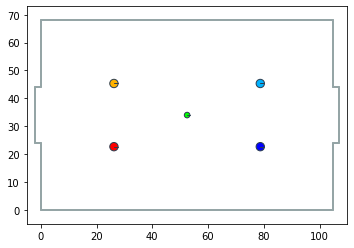

In [2]:
env = gym.make("futbol-v1")
env.render()

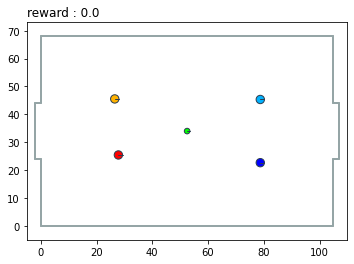

In [3]:
done = False
total_reward = 0
for _ in range(10):
    # action = np.reshape(env.action_space.sample(), -1)
    action = np.array([0,0,0,2])
    ob, reward, done, info = env.step(action, team_side=Side.right)

    plt.clf()
    title_str = ("reward : " + str(reward))
    padding = 5
    ax = plt.axes(xlim=(0 - padding, env.WIDTH + padding), ylim=(0 - padding, env.HEIGHT + padding))
    ax.set_aspect("equal")
    o = pymunk.matplotlib_util.DrawOptions(ax)
    env.space.debug_draw(o)
    plt.title(title_str, loc = 'left')
    display.display(plt.gcf())
    display.clear_output(wait=True)

    total_reward += reward

In [4]:
env.reset()



array([ 0.        ,  0.        ,  0.        ,  0.        , -0.47297297,
       -0.33333333,  0.        ,  0.        , -0.47297297,  0.33333333,
        0.        ,  0.        ,  0.47297297, -0.33333333,  0.        ,
        0.        ,  0.47297297,  0.33333333,  0.        ,  0.        ])